In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file_name = 'air_passengers.feather'

dataset = pd.read_feather(file_name)

In [3]:
dataset

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [4]:
type(dataset)

pandas.core.frame.DataFrame

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
dataset.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
dataset.isna().any()

Month         False
Passengers    False
dtype: bool

<AxesSubplot:>

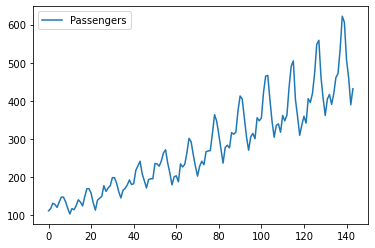

In [8]:
dataset.plot()

In [9]:
series = dataset.set_index('Month')

<AxesSubplot:xlabel='Month'>

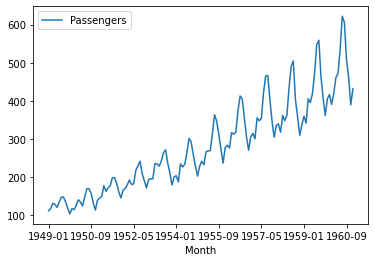

In [10]:
series.plot()

In [11]:
series.head(10)

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
1949-06,135
1949-07,148
1949-08,148
1949-09,136


In [12]:
lookback = 12
sequence = pd.DataFrame(
   {'shift_'+str(s): series['Passengers'].shift(s) 
    for s in range(lookback+1)})[lookback:]

In [13]:
sequence

,shift_0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Month,,,,,,,,,,,,,
1950-01,115,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0
1950-02,126,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0
1950-03,141,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0
1950-04,135,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0
1950-05,125,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08,606,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0,463.0,559.0
1960-09,508,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0,463.0
1960-10,461,508.0,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0


### Separate the target from the predictors

In [14]:
X = sequence.iloc[:,1:]
y = sequence.iloc[:,0]

In [15]:
#standardizing values
max_value = np.max(y)
X/= max_value
y/= max_value

In [16]:
shape = list(X.shape)

shape.insert(1,1)

X = X.values.reshape(shape)

In [17]:
X.shape

(132, 1, 12)

In [18]:
y_train = y[:-24]
y_test = y[-24:] #holdout

X_train = X[:-24]
X_test = X[-24:] #holdout

## Building model

In [19]:
import tensorflow.keras as keras

model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=4, 
              input_shape=(1, lookback)))
model.add(keras.layers.Dense(4, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 272       
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train, y_train, 
          epochs=300, 
          batch_size=8,
          shuffle=True,
          verbose=0)

In [21]:
predictions = model.predict(X_test) * max_value

true_values = y_test * max_value

1/1 [==============================] - 0s 458ms/step


## Performance evaluation

In [22]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true=true_values, y_pred=predictions))
print(f"RMSE for test set: {rmse:0.3}")

RMSE for test set: 34.5


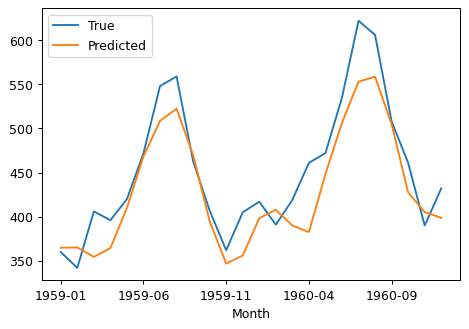

In [23]:
fig, ax = plt.subplots(dpi=90)
true_values.plot()
ax.plot(predictions)
ax.legend(['True', 'Predicted'])
plt.show()